In [1]:
import pandas as pd
import csv
import os
import numpy as np
import datetime
from xlsxwriter.workbook import Workbook
from xlsxwriter import Workbook
import time
from scipy import integrate, stats
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MaxNLocator
from functools import reduce
import re
from sklearn import preprocessing
from matplotlib import colors as mcolors


# %matplotlib inline

In [2]:
Working_dir = os.getcwd()
Data_dir = os.path.join(Working_dir, 'Raw data')
Data_prep_dir = os.path.join(Working_dir, 'Preprocessed data')
Output_dir = os.path.join(Working_dir, 'Analysis')
Plots_dir = os.path.join(Output_dir, 'Plots')

In [3]:
nodes_file_names = ['May2018_idle.csv' , 'June2018_idle.csv', 'July2018_idle.csv', \
                    'September2018.csv', 'October2018.csv', 'November2018.csv', \
                    'December2018.csv' , 'January2019.csv']
nodes_df_names = [item.split('.')[0] for item in nodes_file_names]
summary_index = ['total_dcenergy', 'sys_energy', \
                'cpu_energy', 'mem_energy', 'other_energy', \
                'cpu_en_percent', 'mem_en_percent', \
                'other_en_percent', 'sys_util', 'mem_util', 'cpu_util', \
                'other_util','sys_power_max', 'cpu_power_max',\
                'mem_power_max', 'dcenergy_error_percent', \
                'present_in_months', \
                'avg_exh_temp', 'avg_inlet_temp', \
                'avg_cpu1_temp', 'avg_cpu2_temp', \
                'idle_time_sec', 'working_time_sec', \
                'idle_en_integral']

Drop vs no_drop dfs:

No_drop dataframes contain stats about nodes where the relative error between total_dcenergy and sys_energy (computed through integral) is greater than 5%

In [4]:
nodes_no_drop_df_dict = {}
for file_name, df_name in zip(nodes_file_names, nodes_df_names):
    nodes_no_drop_df_dict[df_name] = pd.read_csv(os.path.join( Output_dir, 'nodes_stats_' + file_name), \
                                         delimiter=";", header=0, index_col=0)
#     nodes_no_drop_df_dict[df_name] = drop_nan_inf_cols_by_row_to_plot(nodes_no_drop_df_dict[df_name])

In [5]:
def drop_nan_inf_cols_by_row_to_plot(df):
    df_output = df.copy()
    
    inf_cols = df_output.loc[:, df_output.columns.to_series()[np.isinf(df_output).any()]]
    df_output.drop(inf_cols, axis=1, inplace=True)
    
    nan_cols = df_output.loc[:, df_output.isna().any()]
    df_output.drop(nan_cols, axis=1, inplace=True)
    return df_output

In [6]:
nodes_df_dict = {}
for file_name, df_name in zip(nodes_file_names, nodes_df_names):
    nodes_df_dict[df_name] = pd.read_csv(os.path.join( Output_dir, 'nodes_stats_' + file_name), \
                                         delimiter=";", header=0, index_col=0)
    to_drop_ix = np.unique(np.append(\
                                     np.where(nodes_df_dict[df_name].loc["dcenergy_error_percent", :].isna())[0], \
                                     np.where(nodes_df_dict[df_name].loc["dcenergy_error_percent", :] > 5.)[0]))
    to_drop = nodes_df_dict[df_name].iloc[:,to_drop_ix].columns.values
    nodes_df_dict[df_name].drop(columns=to_drop, inplace=True)

In [7]:
def extract_mm_YYYY (string):
    year = re.findall(r'\d+', string)[0]
    month = string.split(year)[0]
    return month, year

In [8]:
nodes_summary_no_drop_df = pd.read_csv( os.path.join( Output_dir, 'nodes_summary_all_months_no_drop.csv'), \
                                        sep=';', index_col=0, header=0)
nodes_summary_df = pd.read_csv( os.path.join( Output_dir, 'nodes_summary_all_months.csv'), \
                                        sep=';', index_col=0, header=0)

## Pie-charts with *energy* portions used by CPU, memory and other sources

In [23]:
def plot_energy_cons(data, node, month, year, avg_flag=False, drop_flag=True):
    labels = 'CPU', 'Memory', 'Other'
    data = data.values
    colors = ['lightskyblue', 'lightcoral',  'yellowgreen']# 'gold', 
    
    fig1, ax1 = plt.subplots()
    
    plt.pie(data, labels=labels, colors=colors, autopct='%1.1f%%', shadow=False, startangle=0)
    
    plt.axis('equal')
    
    save_to = (os.path.join( Plots_dir, 'En_cons_categories_cpu_mem_other', 'Categories_avg_en_' + month + '_' + year ) )
    if not avg_flag:
        plt.title(month + ' ' + year + ', Node '+ node)
        save_to = (os.path.join( Output_dir, 'Plots', 'Node_' + node + '_' + month + '_' + year ) )
    else:
        plt.title(month + ' ' + year)
        
    if drop_flag:
        save_to += '.png'
    else:
        save_to += '_no_drop.png'
    plt.tight_layout()
    fig1.savefig(save_to, dpi=900)
    plt.show()

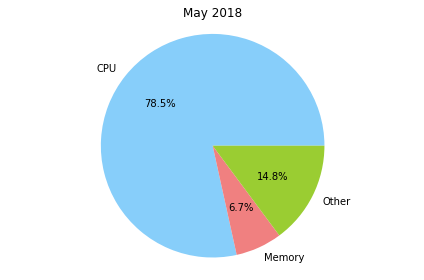

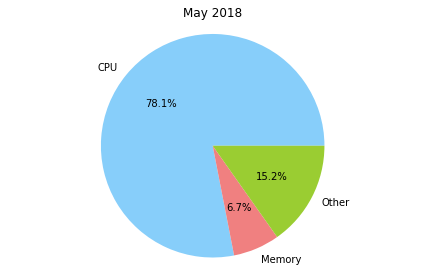

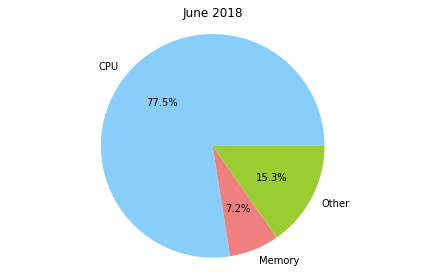

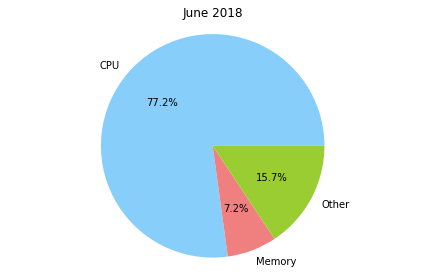

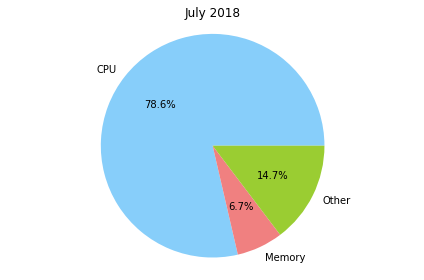

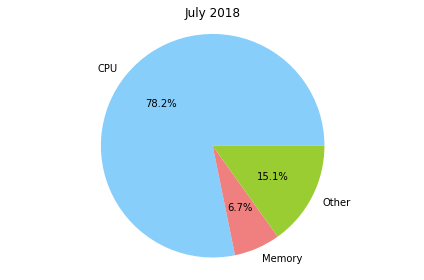

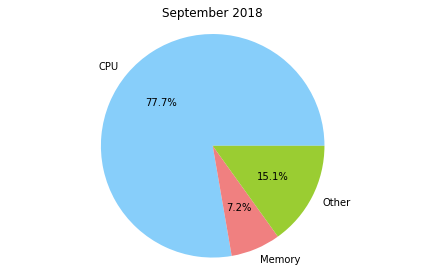

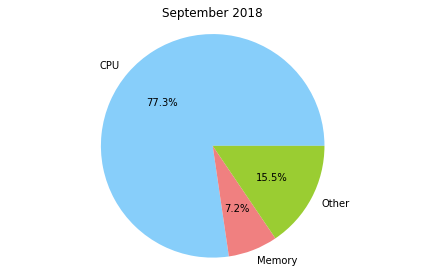

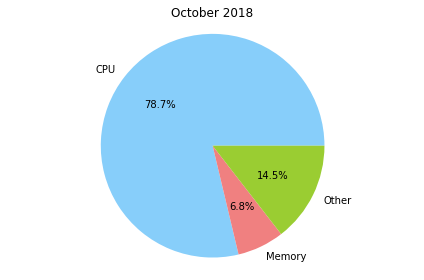

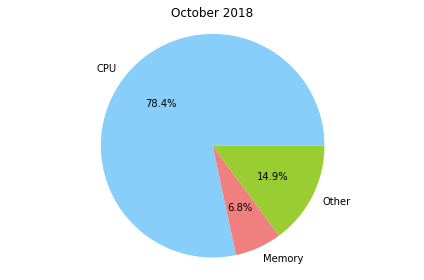

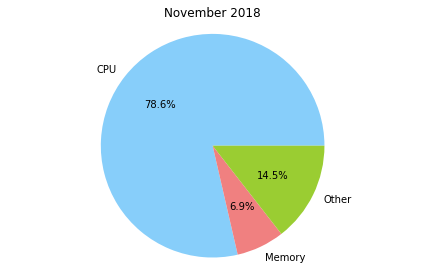

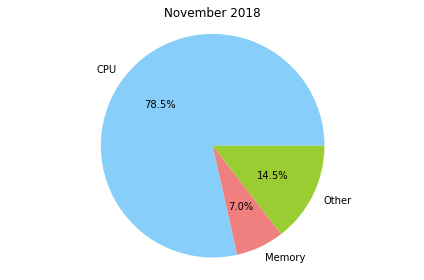

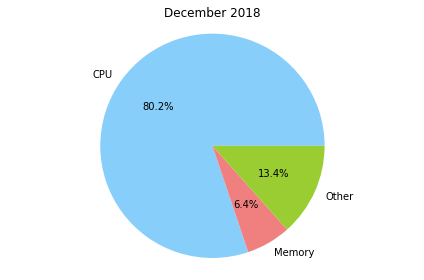

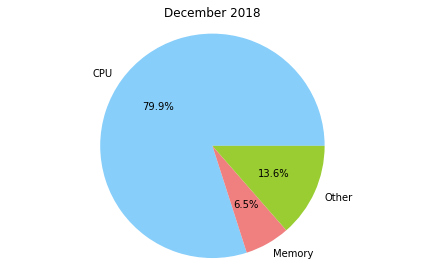

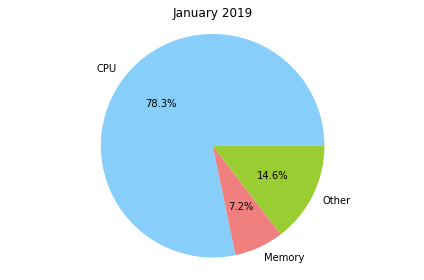

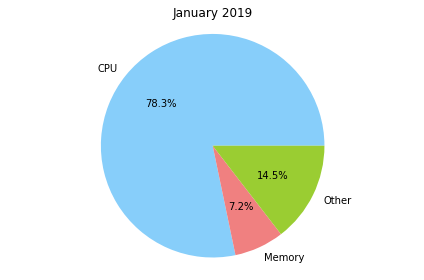

In [24]:
for df_name in nodes_df_names:
    year = re.findall(r'\d+', df_name)[0]
    month = df_name.split(year)[0]
    data=nodes_df_dict[df_name].iloc[5:8,:].mean(axis=1)
    plot_energy_cons(data=data, \
                     node='', \
                     month=month, year=year, avg_flag=True)
    no_drop_data = nodes_no_drop_df_dict[df_name].iloc[5:8,:].mean(axis=1)
    if not np.array_equal(no_drop_data.values, data.values):
        energy_category_no_drop = drop_nan_inf_cols_by_row_to_plot(nodes_no_drop_df_dict[df_name].iloc[5:8,:])
#         print(energy_category_no_drop.mean(axis=1))
        plot_energy_cons(data=energy_category_no_drop.mean(axis=1), \
                     node='', \
                     month=month, year=year, avg_flag=True, drop_flag=False)

[78.5260218   6.89125906 14.58271914] 100.00000000000001


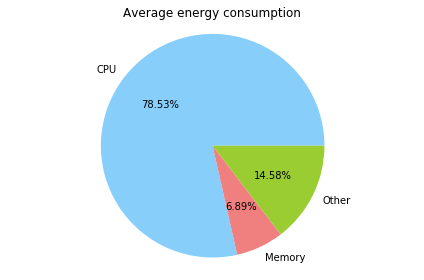

In [30]:
colors = ['lightskyblue', 'lightcoral',  'yellowgreen']
labels = 'CPU', 'Memory', 'Other'
data = nodes_summary_df.\
                    loc[['cpu_en_percent', 'mem_en_percent', 'other_en_percent'], 'avg_all_nodes']
fig1, ax1 = plt.subplots()
print(data.values, data.values.sum())
plt.pie(x=data.values, \
        labels=labels, colors=colors, autopct='%1.2f%%', shadow=False, startangle=0)
plt.axis('equal')
plt.title('Average energy consumption')
plt.tight_layout()
fig1.savefig(os.path.join( Output_dir, 'Plots', \
                          'En_cons_categories_cpu_mem_other', 'Categories_avg_en_cons_all_months.png' ), dpi=900 )
plt.show()

[77.73168289  6.8476298  15.4206873 ]


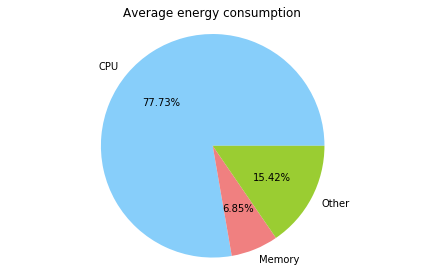

In [28]:
colors = ['lightskyblue', 'lightcoral',  'yellowgreen']
labels = 'CPU', 'Memory', 'Other'
data = pd.read_csv(os.path.join( Output_dir, 'nodes_summary_all_months_no_drop.csv'), \
                                         delimiter=";", header=0, index_col=0).\
                    loc[['cpu_en_percent', 'mem_en_percent', 'other_en_percent'], 'avg_all_nodes']
fig1, ax1 = plt.subplots()
print(data.values)
plt.pie(x=data.values, \
        labels=labels, colors=colors, autopct='%1.2f%%', shadow=False, startangle=0)
plt.axis('equal')
plt.title('Average energy consumption')
plt.tight_layout()
fig1.savefig(os.path.join( Output_dir, 'Plots', \
                          'En_cons_categories_cpu_mem_other', 'Categories_avg_en_cons_all_months_no_drop.png' ), dpi=900 )
plt.show()

## Energy consumption for each node - histogram for each month
- Nodes are sorted by their energy consumption
- Node IDs do not correspond to real node names like 1..cresc6x001. Node IDs are fictionary labels for ease of understanding the graph: 

    $y$ axis - energy consumed by a node during the month mentionted in the title;

    $x$ axis - all the nodes 

### a) Based on dcenergy measurements

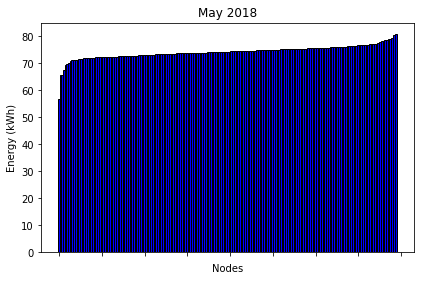

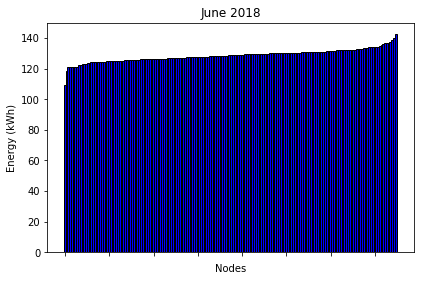

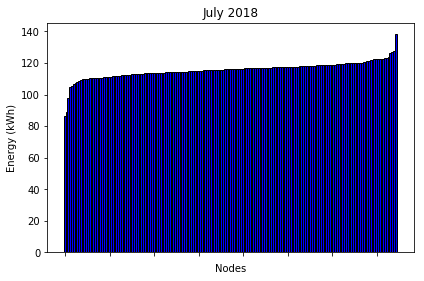

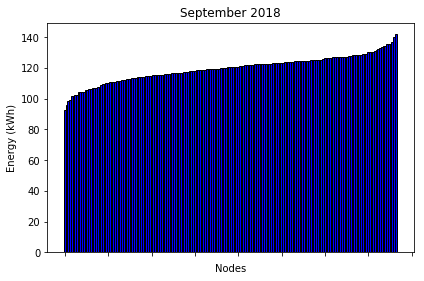

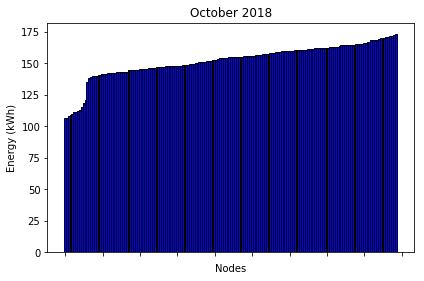

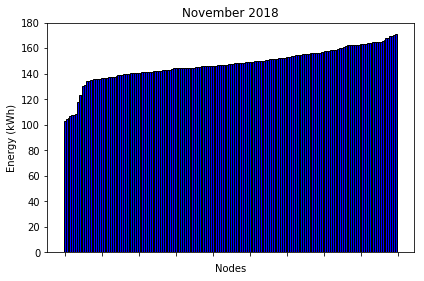

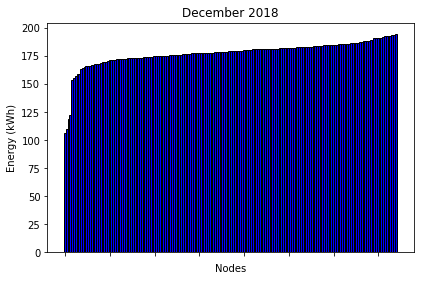

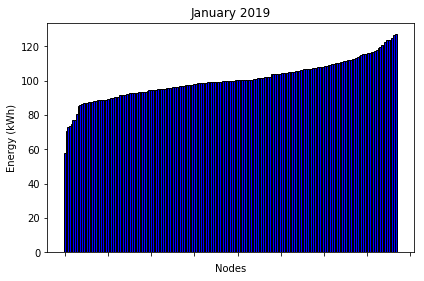

In [9]:
for df_name in nodes_df_names:
    data = nodes_df_dict[df_name].loc['total_dcenergy',:].sort_values(ascending=True)
    fig, ax = plt.subplots()
    N = len(nodes_df_dict[df_name].columns.values)
    ind = np.arange(N)
    p1 = plt.bar(ind, data, color='blue', edgecolor='black', width=1.5)#en_exit_jobs_kWh
    plt.ylabel('Energy (kWh)')
    plt.xlabel('Nodes')
    plt.xticks(visible=False)
    plt.gca().xaxis.set_label_coords(0.5, -0.05) 
    month, year = extract_mm_YYYY(df_name)
    plt.title(month + ' ' + year)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.tight_layout()
    fig.savefig( os.path.join( Plots_dir, 'En_cons_total', 'En_cons_by_nodes_' + df_name + '.png'),dpi=900)
    plt.show()

## b) Based on system energy calculation - without dropping nodes, where sys_energy <> dc_energy
Check DC energy graphs for May in the "Preprocessing" file: the problem is in energy meter and not in the power meter.

214


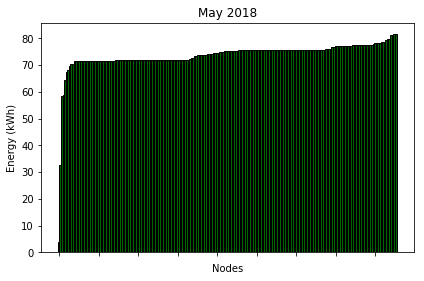

214


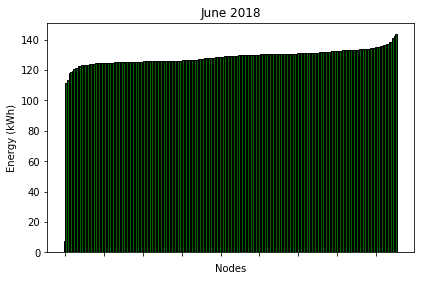

214


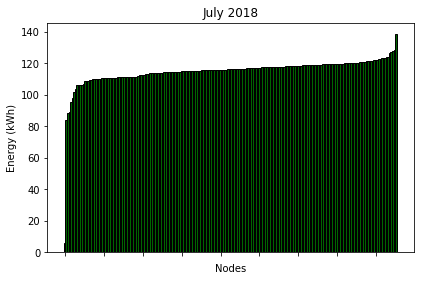

214


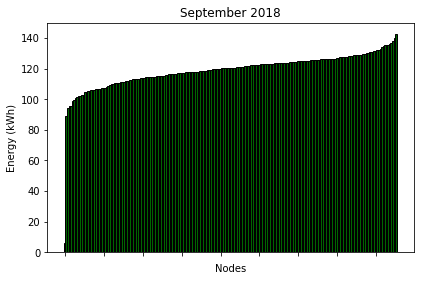

214


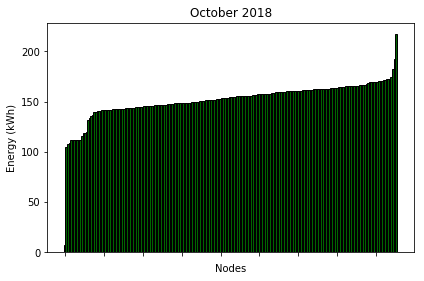

213


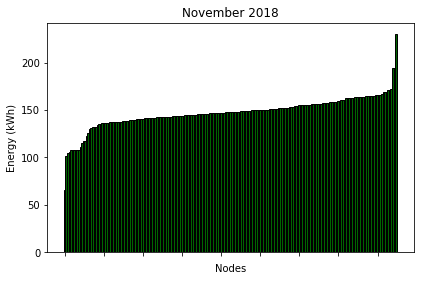

213


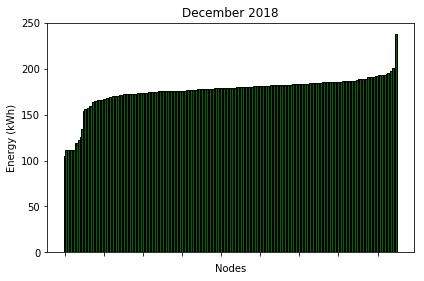

213


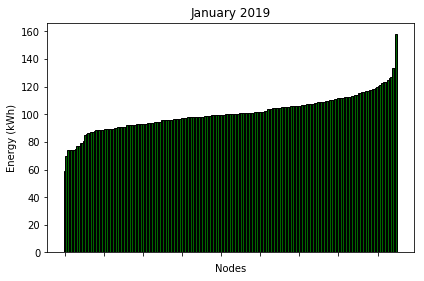

In [10]:
for df_name in nodes_df_names:
    data = nodes_no_drop_df_dict[df_name].loc['sys_energy',:].sort_values(ascending=True)
    data = data[data > 0.]
    fig, ax = plt.subplots()
    N = len(data)
    print(N)
    ind = np.arange(N)
    p1 = plt.bar(ind, data, color='darkgreen', edgecolor='black', width=1.5)#en_exit_jobs_kWh
    plt.ylabel('Energy (kWh)')
    plt.xlabel('Nodes')
    plt.xticks(visible=False)
    plt.gca().xaxis.set_label_coords(0.5, -0.05) 
    
#     plt.xticks([int(re.findall(r'\d+', x)[1]) for x in nodes_no_drop_df_dict[df_name].columns.values][::10], rotation=90)
    month, year = extract_mm_YYYY(df_name)
    plt.title(month + ' ' + year)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.tight_layout()
    fig.savefig( os.path.join( Plots_dir, 'En_cons_total', 'Sys_cons_by_nodes_' + df_name + '.png'),dpi=900)
    plt.show()

-----
## Monthly energy consumption of the whole cluster 
### a) Based on dcenergy measurements - uneven data, missing data 

In [11]:
energy_by_month = pd.DataFrame(data=0, index=nodes_df_names, columns=['total_dcenergy_MWh', 'total_sys_energy_no_drop_MWh'])

for df_name in nodes_df_names:
    energy_by_month.loc[df_name, 'total_dcenergy_MWh'] = nodes_df_dict[df_name].loc['total_dcenergy', :].sum()
    energy_by_month.loc[df_name, 'total_sys_energy_no_drop_MWh'] = nodes_no_drop_df_dict[df_name].loc['sys_energy', :].sum()

energy_by_month = energy_by_month/1000.
energy_by_month

,total_dcenergy_MWh,total_sys_energy_no_drop_MWh
May2018_idle,14.693392,15.760777
June2018_idle,24.173116,27.456353
July2018_idle,21.623925,24.611164
September2018,22.968813,25.461291
October2018,27.047608,32.489585
November2018,26.539778,31.381473
December2018,33.022540,37.567028
January2019,19.393103,21.489490


In [18]:
print(energy_by_month.total_dcenergy_MWh.sum(), energy_by_month.total_sys_energy_no_drop_MWh.sum())

189.46227394 216.22942401944442


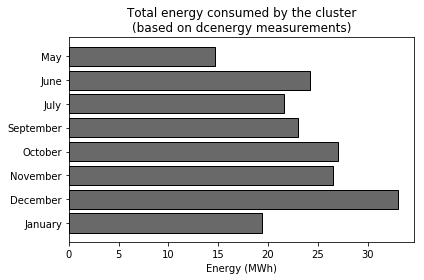

In [12]:
fig, ax = plt.subplots()

N = len(energy_by_month.index)
ind = np.arange(N)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

p1 = plt.barh(ind, energy_by_month.total_dcenergy_MWh, color='dimgrey', edgecolor='black')#saddlebrown
plt.title('Total energy consumed by the cluster\n(based on dcenergy measurements)')
plt.xlabel('Energy (MWh)')
plt.yticks(ind, ('May', 'June', 'July',\
                'September','October', 'November', 'December',\
                'January'))
ax.invert_yaxis()
plt.tight_layout()
fig.savefig(os.path.join(Plots_dir, 'energy_cons_by_month_dcenergy.png'),dpi=900)
plt.show()

## Monthly energy consumption of the whole cluster 
### b) Based on sys_power measurements - integral taken over time - more precise as all the nodes are present
However, the sys_power measurements can contain technical sensor uncertainties 

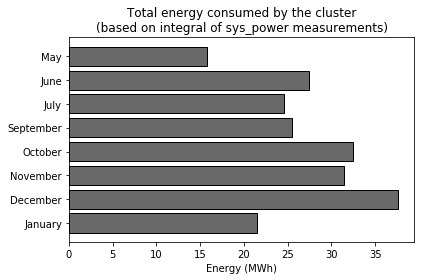

In [13]:
fig, ax = plt.subplots()

N = len(energy_by_month.index)
ind = np.arange(N)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

p1 = plt.barh(ind, energy_by_month.total_sys_energy_no_drop_MWh, color='dimgray', edgecolor='black')#saddlebrown

plt.title('Total energy consumed by the cluster\n(based on integral of sys_power measurements)')
plt.xlabel('Energy (MWh)')
plt.yticks(ind, ('May', 'June', 'July',\
                'September','October', 'November', 'December',\
                'January'))
ax.invert_yaxis()
plt.tight_layout()
fig.savefig(os.path.join(Plots_dir, 'energy_cons_by_month_sys_power_int.png'),dpi=300)
plt.show()

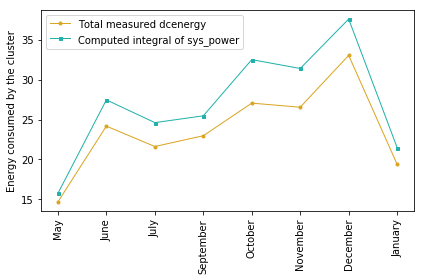

In [14]:
fig, ax = plt.subplots()

N = len(energy_by_month.index)
ind = np.arange(N)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

p1 = plt.plot(ind, energy_by_month.total_dcenergy_MWh, color='goldenrod', \
              linestyle='-', marker='o',\
              markersize=3, linewidth=1)#color='lightseagreen''k',linestyle=':'

p2 = plt.plot(ind, energy_by_month.total_sys_energy_no_drop_MWh, color='lightseagreen', \
              linestyle='-', marker='s',\
              markersize=3, linewidth=1)#color='lightseagreen''k',linestyle='-.'
lgd = plt.legend((p1[0], p2[0]), ( 'Total measured dcenergy', 'Computed integral of sys_power' ),\
           loc='upper left')
plt.ylabel('Energy consumed by the cluster')
plt.xticks(ind, ('May', 'June', 'July',\
                'September','October', 'November', 'December',\
                'January'), rotation=90)
plt.tight_layout()
fig.savefig(os.path.join(Plots_dir, 'Total_en_dcenergy_vs_sys_power_integral.png'), bbox_inches='tight',\
           dpi=1200)
plt.show()

-----
## Temperature profiles


## Exhaust and inlet tempterature taken at average for every node and every month

u'Temperature (℃)')

       Relative_error_l2
exh             0.051359
inlet           0.019853
cpu1            0.036726
cpu2            0.038949


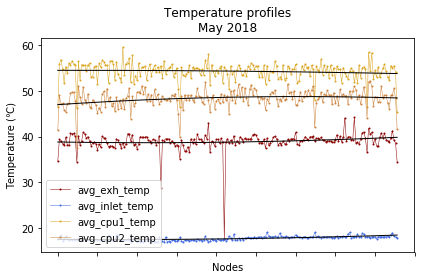

       Relative_error_l2
exh             0.044847
inlet           0.018521
cpu1            0.031298
cpu2            0.030816


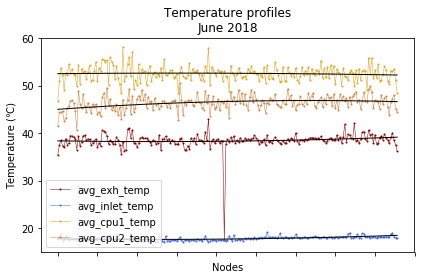

       Relative_error_l2
exh             0.050020
inlet           0.019277
cpu1            0.039104
cpu2            0.041920


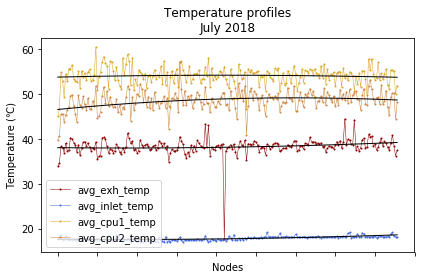

       Relative_error_l2
exh             0.057834
inlet           0.018849
cpu1            0.058946
cpu2            0.060761


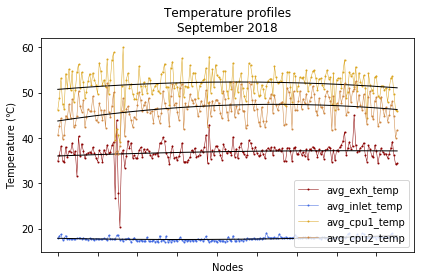

       Relative_error_l2
exh             0.059423
inlet           0.019487
cpu1            0.060723
cpu2            0.059985


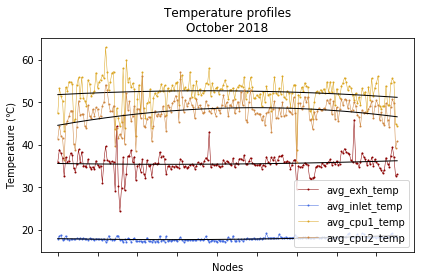

       Relative_error_l2
exh             0.066224
inlet           0.023464
cpu1            0.075509
cpu2            0.071828


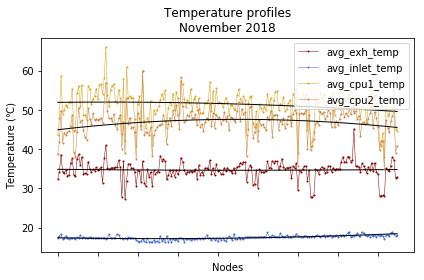

       Relative_error_l2
exh             0.068079
inlet           0.022780
cpu1            0.075101
cpu2            0.073409


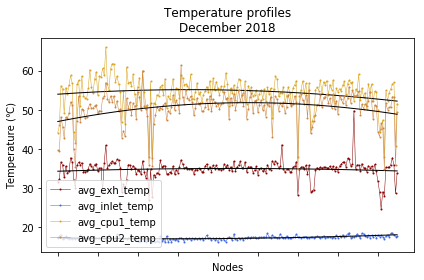

       Relative_error_l2
exh             0.080617
inlet           0.022679
cpu1            0.080364
cpu2            0.078841


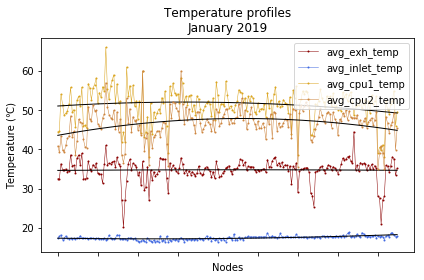

In [19]:
temp_types = ['exh', 'inlet', 'cpu1', 'cpu2']
temp_titles = ['Exhaust', 'Inlet', 'CPU 1', 'CPU 2']
temp_colors = ['darkred', 'royalblue', 'goldenrod', 'peru']

error_sum = pd.DataFrame(columns=['Relative_error_l2'], index=temp_types)

for df_name in nodes_df_names:
    fig, ax = plt.subplots()
    month_df = nodes_no_drop_df_dict[df_name]
    data = drop_nan_inf_cols_by_row_to_plot(month_df.filter(regex=('temp$'), axis=0))
#     data.sort_values(by=['avg_exh_temp'], axis=1, inplace=True)
    N = len(data.columns.values)
    x = np.arange(N)
    
    error_sum.loc[temp_types, 'Relative_error_l2'] = 0
    
    for (temp_type, temp_name, color) in zip(temp_types, temp_titles, temp_colors):

        y = data.loc['avg_'+temp_type+'_temp',:]
        z = np.poly1d(np.polyfit(x, y, 2))
        plt.plot(x, y, marker='o', markersize=1, linewidth=0.5, color=color)
        plt.plot(x, z(x), color='black', linewidth=1)
        
        error_sum.loc[temp_type, 'Relative_error_l2'] = np.linalg.norm(y-z(x))/np.linalg.norm(y)
    
    print(error_sum)
    
    plt.ylabel('Temperature (℃)')
    plt.xlabel('Nodes')
    plt.xticks(visible=False)
    plt.gca().xaxis.set_label_coords(0.5, -0.05)
    month, year = extract_mm_YYYY(df_name)
    plt.title('Temperature profiles\n' + month + ' ' + year)
    plt.legend()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.tight_layout()
    fig.savefig( os.path.join( Plots_dir, 'Temp_profile_by_nodes_' + df_name + '.png'),dpi=900 )
    plt.show()

5.860424028268547 0.24079636412611535


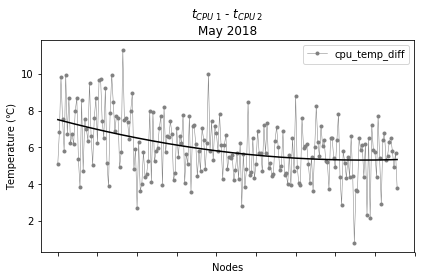

6.11963746223563 0.23003829680697802


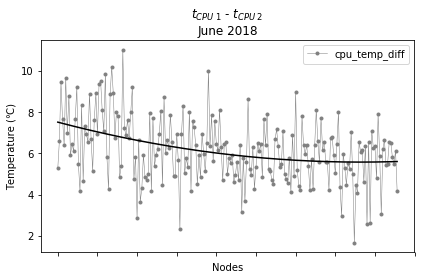

5.497762863534682 0.263146517870979


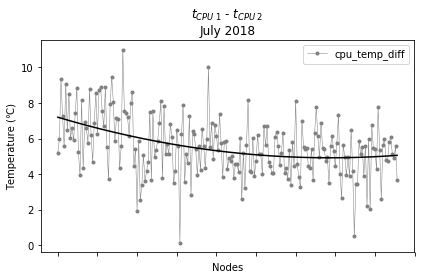

5.201027510772285 0.2781645281545378


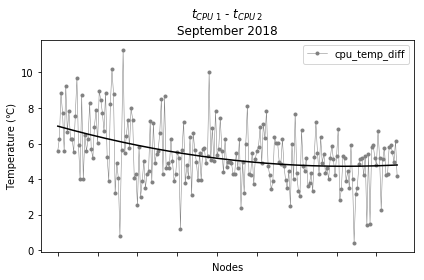

4.398443966408237 0.32225913354011665


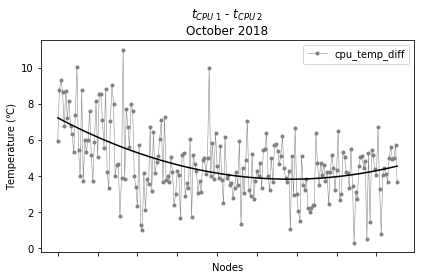

4.28438995215312 0.3324872228406247


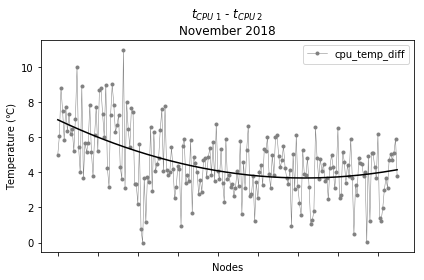

3.6875921013852135 0.3664081160971589


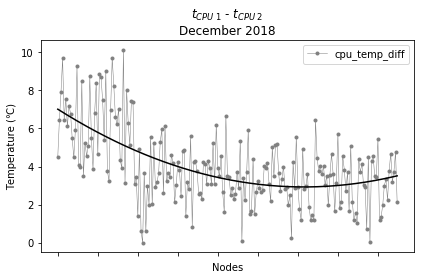

4.606168976307551 0.3308002400022433


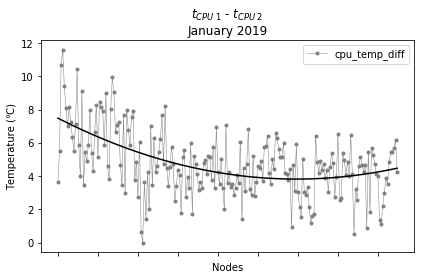

In [16]:
error_sum=0
for df_name in nodes_df_names:
    fig, ax = plt.subplots()
    month_df = nodes_no_drop_df_dict[df_name]
    data = drop_nan_inf_cols_by_row_to_plot(month_df.filter(regex=('temp$'), axis=0))
    data.loc['cpu_temp_diff',:] = abs(data.loc['avg_cpu1_temp', :] - data.loc['avg_cpu2_temp', :])
    N = len(data.columns.values)
    x = np.arange(N)
    y = data.loc['cpu_temp_diff', :]
    z = np.poly1d(np.polyfit(x, y, 2))

    plt.plot(x, y, color='grey', marker='o', markersize=3, linewidth=0.5)#en_exit_jobs_kWh, edgecolor='black', width=1.5
    plt.plot(x, z(x), color='black')
    
    plt.ylabel('Temperature (℃)')
    plt.xlabel('Nodes')
    plt.xticks(visible=False)
    plt.gca().xaxis.set_label_coords(0.5, -0.05)
    error_sum += np.linalg.norm(y-z(x))/np.linalg.norm(y)
    print(y.median(), np.linalg.norm(y-z(x))/np.linalg.norm(y))
    month, year = extract_mm_YYYY(df_name)
    plt.title(r'$t_{CPU \; 1}$ - $t_{CPU \; 2}$' +'\n' + month + ' ' + year)
    plt.legend()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.tight_layout()
    fig.savefig( os.path.join( Plots_dir, 'CPU_temp_diff_by_nodes_' + df_name + '.png'),dpi=900 )
    plt.show()

In [17]:
error_sum/8

0.2955125524298442

## Average temperatures for all nodes over all months

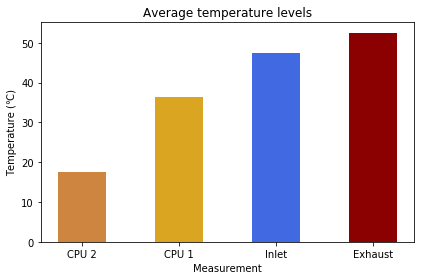

In [20]:
# Title for each bar
temp_titles = ['Exhaust', 'Inlet', 'CPU 1', 'CPU 2']

# Colours
temp_colors = ['darkred', 'royalblue', 'goldenrod', 'peru']

# Height of bars
data = nodes_summary_no_drop_df.filter(regex=(r'temp$'), axis=0).iloc[:,-1].values

# Bars horizontal positions
x_pos = np.arange(len(data))

# Sort lists by values of the first one
data, temp_titles, temp_colors = zip(*sorted(zip(data, temp_titles, temp_colors)))

plt.bar(x_pos, data, color=temp_colors, width=0.5)
plt.xticks(x_pos, temp_titles)
plt.ylabel('Temperature (℃)')
plt.xlabel('Measurement')
plt.title('Average temperature levels')
plt.tight_layout()
fig.savefig( os.path.join( Plots_dir, 'Temp_levels_global_avg_v2.png'),dpi=900 )
plt.show()

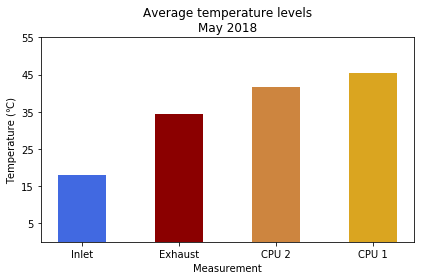

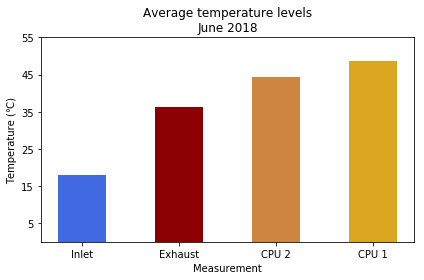

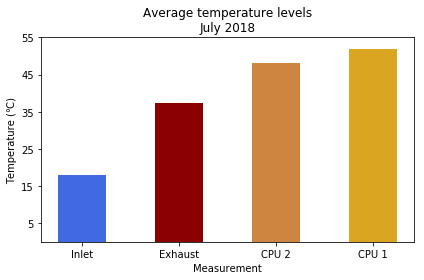

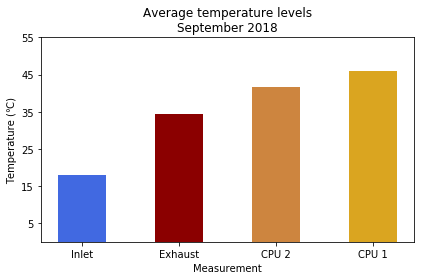

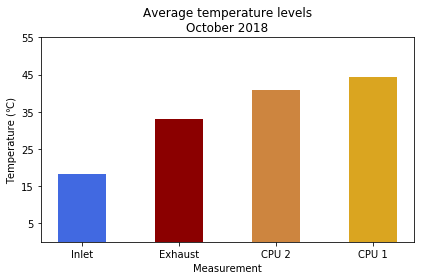

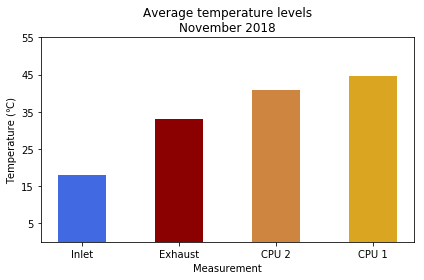

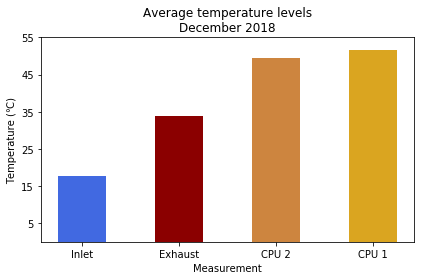

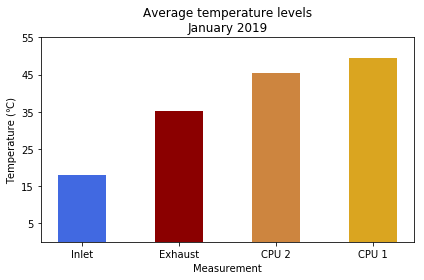

In [31]:
for df_name in nodes_df_names:
    fig, ax = plt.subplots()
    # Height of bars
    month_df = nodes_no_drop_df_dict[df_name]
    data = drop_nan_inf_cols_by_row_to_plot(month_df.filter(regex=('temp$'), axis=0)).iloc[:,-1].values

    # Bars horizontal positions
    x_pos = np.arange(len(data))

    # Sort lists by values of the first one
    # Title for each bar
    temp_titles = ['Exhaust', 'Inlet', 'CPU 1', 'CPU 2']
    # Colours
    temp_colors = ['darkred', 'royalblue', 'goldenrod', 'peru']
    data, temp_titles, temp_colors = zip(*sorted(zip(data, temp_titles, temp_colors)))

    # Plot
    plt.bar(x_pos, data, color=temp_colors, width=0.5)
    
    plt.xticks(x_pos, temp_titles)
    plt.ylabel('Temperature (℃)')
    plt.xlabel('Measurement')
    plt.yticks(range(5,60,10))
    month, year = extract_mm_YYYY(df_name)
    plt.title('Average temperature levels\n' + month + ' ' + year)
    plt.tight_layout()
    fig.savefig( os.path.join( Plots_dir, 'Temperature', 'Temp_levels_' + df_name + '.png'),dpi=900 )
    plt.show()

## Monthly avg temperatures

In [21]:
temp_types = ['exh', 'inlet', 'cpu1', 'cpu2']
temp_by_month = pd.DataFrame(data=0, index=nodes_df_names, columns=['avg_exh_temp', 'avg_inlet_temp', \
                                                                    'avg_cpu1_temp', 'avg_cpu2_temp'])

for df_name in nodes_df_names:
    temp_stats_month_df = drop_nan_inf_cols_by_row_to_plot(nodes_no_drop_df_dict[df_name].filter(regex=('temp$'), axis=0))
    for col_name in temp_by_month.columns.values:
        temp_by_month.loc[df_name, col_name] = temp_stats_month_df.loc[col_name, :].mean()
temp_by_month.loc[:,'delta_t'] = temp_by_month.avg_exh_temp - temp_by_month.avg_inlet_temp
temp_by_month.loc[:,'cpu1_cooled_delta_t'] = temp_by_month.avg_cpu1_temp - temp_by_month.avg_exh_temp
temp_by_month.loc[:,'cpu2_cooled_delta_t'] = temp_by_month.avg_cpu2_temp - temp_by_month.avg_exh_temp
temp_by_month

,avg_exh_temp,avg_inlet_temp,avg_cpu1_temp,avg_cpu2_temp,delta_t,cpu1_cooled_delta_t,cpu2_cooled_delta_t
May2018_idle,38.965515,17.724978,54.287660,48.317119,21.240537,15.322144,9.351604
June2018_idle,38.456678,17.829124,52.548393,46.396313,20.627554,14.091715,7.939635
July2018_idle,38.303140,17.913263,54.010380,48.471586,20.389877,15.707240,10.168446
September2018,36.889712,17.839173,51.886318,46.523138,19.050538,14.996607,9.633427
October2018,35.561975,17.878794,52.225273,47.560097,17.683181,16.663297,11.998121
November2018,34.687275,17.482738,51.327216,46.815880,17.204537,16.639941,12.128604
December2018,34.801069,17.305861,54.419349,50.500044,17.495208,19.618280,15.698975
January2019,34.738829,17.460380,51.334304,46.610115,17.278449,16.595475,11.871287


In [39]:
temp_by_month.cpu1_cooled_delta_t.mean(), temp_by_month.cpu2_cooled_delta_t.mean()

(16.20424722484208, 11.09866819581147)

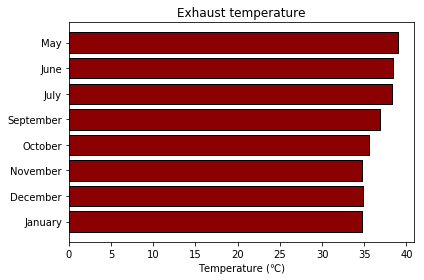

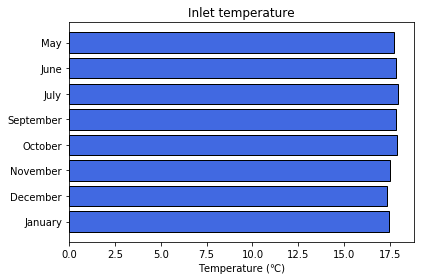

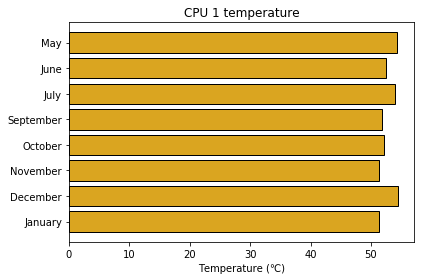

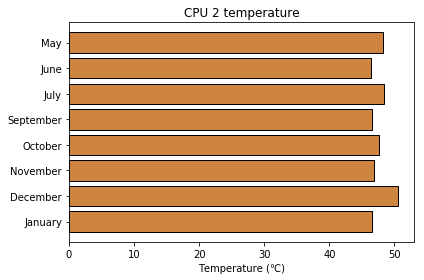

In [32]:
temp_titles = ['Exhaust', 'Inlet', 'CPU 1', 'CPU 2']
temp_colors = ['darkred', 'royalblue', 'goldenrod', 'peru']

N = len(temp_by_month.index)
ind = np.arange(N)

for (col_name, temp_title, color) in zip(temp_by_month.columns.values, temp_titles, temp_colors):

    fig, ax = plt.subplots()

    p1 = plt.barh(ind, temp_by_month.loc[:,col_name], color=color, edgecolor='black')#saddlebrown

    plt.title( temp_title + ' temperature')
    plt.xlabel('Temperature (℃)')
    plt.yticks(ind, ('May', 'June', 'July',\
                    'September','October', 'November', 'December',\
                    'January'))
    ax.invert_yaxis()
    plt.tight_layout()
    fig.savefig(os.path.join(Plots_dir, temp_title+'_temp_by_month.png'), dpi=900)
    plt.show()

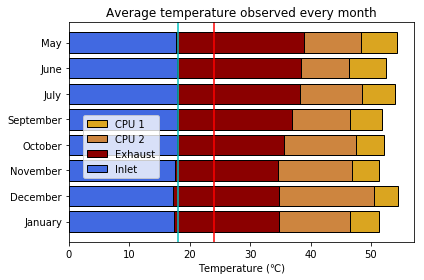

In [33]:
temp_titles = ['Exhaust', 'Inlet', 'CPU 1', 'CPU 2']
temp_colors = ['darkred', 'royalblue', 'goldenrod', 'peru']

fig, ax = plt.subplots()

N = len(temp_by_month.index)
ind = np.arange(N)

p4 = plt.barh(ind, temp_by_month.loc[:,'avg_cpu1_temp'], color=temp_colors[2], edgecolor='black')#saddlebrown
p3 = plt.barh(ind, temp_by_month.loc[:,'avg_cpu2_temp'], color=temp_colors[3], edgecolor='black')#saddlebrown
p2 = plt.barh(ind, temp_by_month.loc[:,'avg_exh_temp'], color=temp_colors[0], edgecolor='black')#saddlebrown
p1 = plt.barh(ind, temp_by_month.loc[:,'avg_inlet_temp'], color=temp_colors[1], edgecolor='black')#saddlebrown

xcoords = [18., 24.]
colors = ['c', 'r']
labels = ['Cold aisle setpoint', 'Hot aisle setpoint']
for xc,c,line_label in zip(xcoords,colors, labels):
    plt.axvline(x=xc, label=line_label, c=c)

# Decoration
plt.title( 'Average temperature observed every month')
plt.xlabel('Temperature (℃)')
plt.yticks(ind, ('May', 'June', 'July',\
                'September','October', 'November', 'December',\
                'January'))
ax.invert_yaxis()

lgd = plt.legend((p4[0], p3[0], p2[0], p1[0]), ('CPU 1', 'CPU 2', 'Exhaust', 'Inlet', ),\
             loc='upper center', bbox_to_anchor=(0.15, 0.6))

# Y-labels not cut off
plt.tight_layout()

fig.savefig(os.path.join(Plots_dir, 'Temp_levels_by_month.png'), dpi=900)
plt.show()

## $\Delta$Temperature = exhaust - inlet

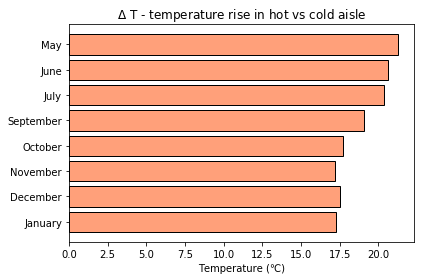

In [34]:
fig, ax = plt.subplots()

N = temp_by_month.shape[0]
ind = np.arange(N)    
width = 0.35

p1 = plt.barh(ind, temp_by_month.delta_t, color='lightsalmon', edgecolor='black')#saddlebrown

plt.title(r'$\Delta$ T - temperature rise in hot vs cold aisle')
plt.xlabel('Temperature (℃)')
plt.yticks(ind, ('May', 'June', 'July',\
                'September','October', 'November', 'December',\
                'January'))
ax.invert_yaxis()
plt.tight_layout()
fig.savefig(os.path.join(Plots_dir, 'Delta_t_by_month.png'),dpi=900)
plt.show()

## $\Delta$ T ranges by nodes for every month

0.0035682426405010403 26.139699381078696 21.369353410097435


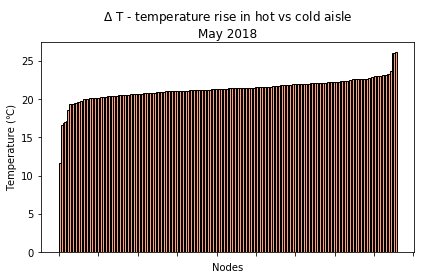

0.006628502561014216 26.0 20.72689201316183


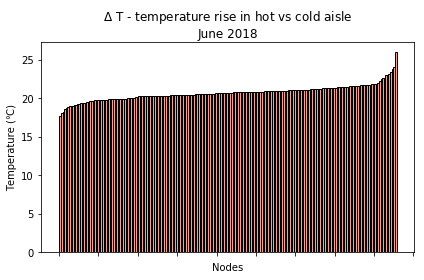

0.011671686746989707 26.259507829977636 20.41163310961969


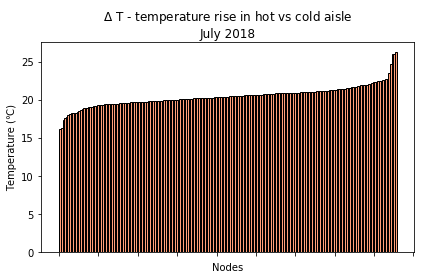

2.921445144182961 26.979781239642023 19.098442161087174


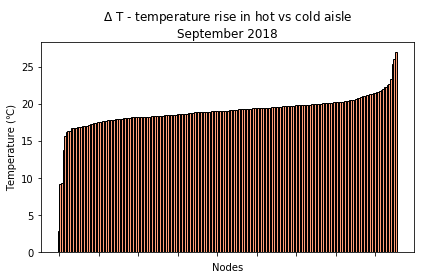

6.727006444053899 27.724077328646747 17.686530014641285


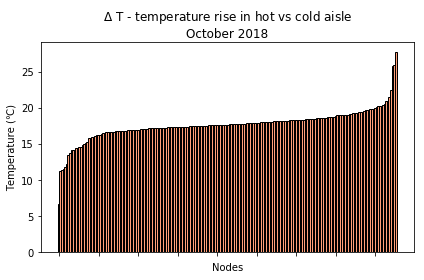

9.956638755980862 27.381393957523176 17.360047846889948


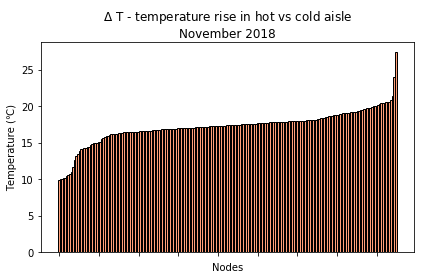

6.7612028301886795 32.331859711170054 17.746462264150942


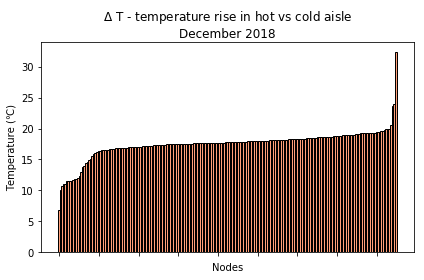

3.005361930294903 26.77469825659366 17.60661600357622


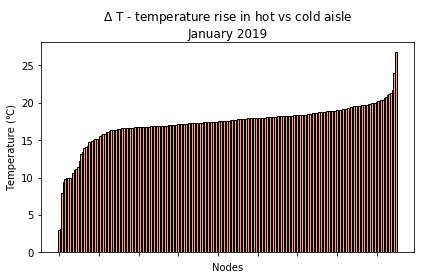

In [35]:
for df_name in nodes_df_names:
    temp_stats_month_df = drop_nan_inf_cols_by_row_to_plot(nodes_no_drop_df_dict[df_name].filter(regex=('temp$'), axis=0))
    
    data = (temp_stats_month_df.loc['avg_exh_temp', :] - temp_stats_month_df.loc['avg_inlet_temp', :]).sort_values()
    print(data.min(), data.max(), data.median())
    fig, ax = plt.subplots()
    N = temp_stats_month_df.shape[1]
    ind = np.arange(N)
    p1 = plt.bar(ind, data, color='lightsalmon', edgecolor='black', width=1.5)
    plt.ylabel('Temperature (℃)')
    plt.xlabel('Nodes')
    plt.xticks(visible=False)
    plt.gca().xaxis.set_label_coords(0.5, -0.05) 
    month, year = extract_mm_YYYY(df_name)
    plt.title(r'$\Delta$ T - temperature rise in hot vs cold aisle' +'\n' + month + ' ' + year)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.tight_layout()
    fig.savefig( os.path.join( Plots_dir, 'Delta_t_by_nodes_' + df_name + '.png'),dpi=900)
    plt.show()

## Idle power use estimation
$\leq 200$ kWh of power use is idle mode


If sys_power level is registered to be $p^1_{{minus\;200}}$ for timestamp $t^1$, then it will be assumed that this power level was observed from the previous timestamp $t^0$ until $t^1$

c:\users\aagri\appdata\local\programs\python\python35\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


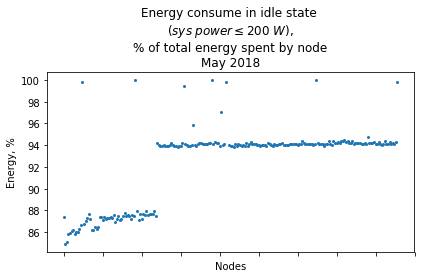

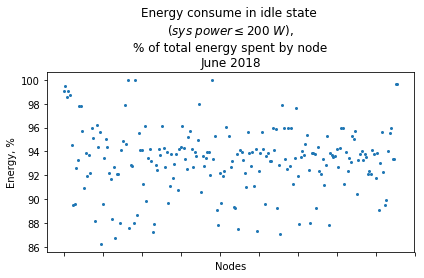

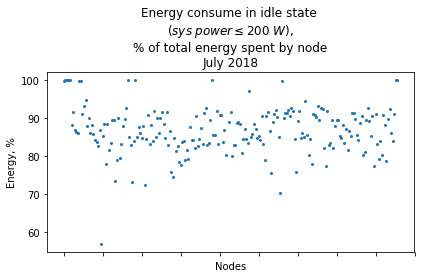

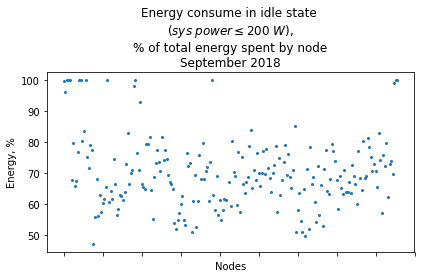

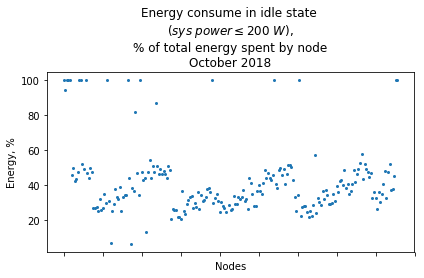

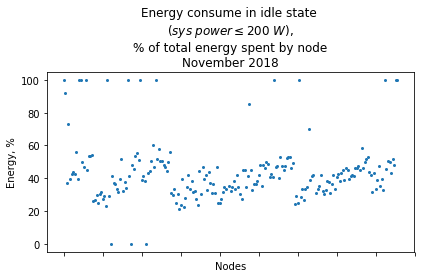

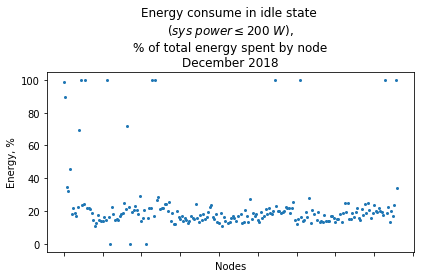

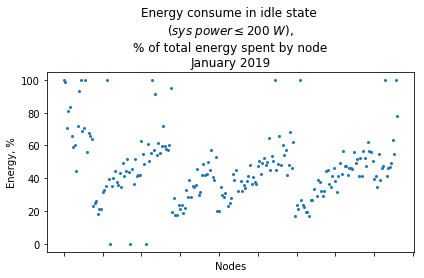

In [41]:
for df_name in nodes_df_names:
    fig, ax = plt.subplots()
    month_df = nodes_no_drop_df_dict[df_name]
    data = month_df.loc['idle_en_integral', :] / month_df.loc['sys_energy', :] * 100.
    N = len(data)
    x = np.arange(N)
        

    y = data
    z = np.poly1d(np.polyfit(x, y, 10))
    plt.scatter(x, y, marker='o', s=4)
#     plt.plot(x, y, marker='o', markersize=1, linewidth=0.5, color=color)
#     plt.plot(x, z(x), color='black', linewidth=1)
        
    plt.ylabel('Energy, %')
    plt.xlabel('Nodes')
    plt.xticks(visible=False)
    plt.gca().xaxis.set_label_coords(0.5, -0.05)
    month, year = extract_mm_YYYY(df_name)
    plt.title('Energy consume in idle state \n'+r'$(sys \; power \leq 200 \; W)$,'+'\n% of total energy spent by node\n' + month + ' ' + year)
    plt.legend()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.tight_layout()
    fig.savefig( os.path.join( Plots_dir, 'Portion_idle_energy_of_nodes_' + df_name + '.png'),dpi=900 )
    plt.show()

c:\users\aagri\appdata\local\programs\python\python35\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


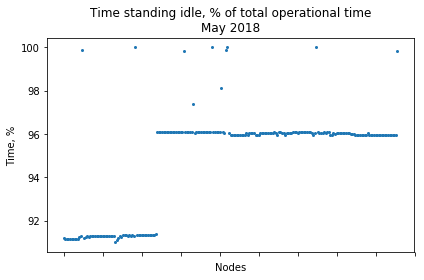

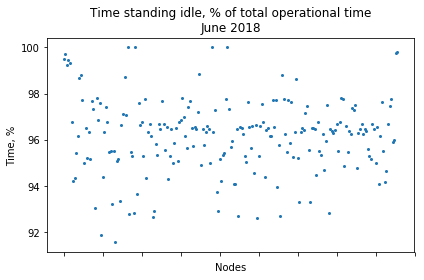

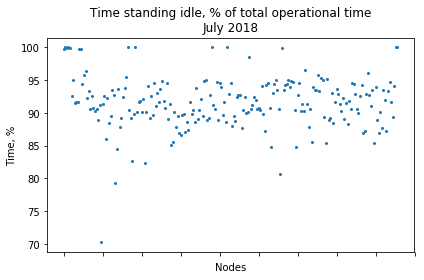

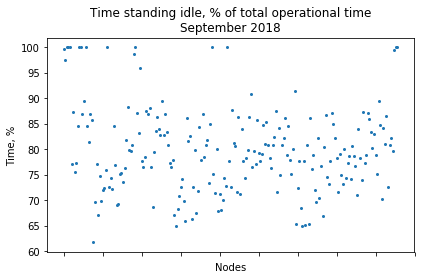

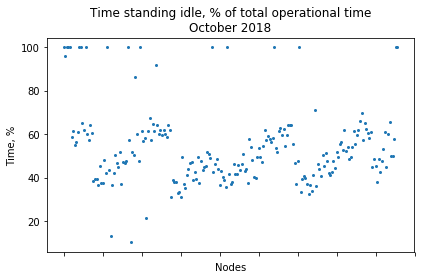

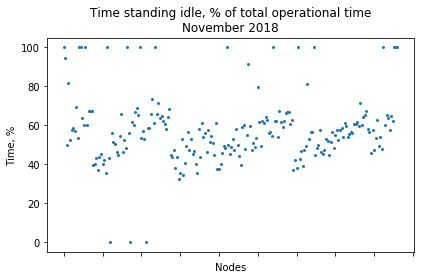

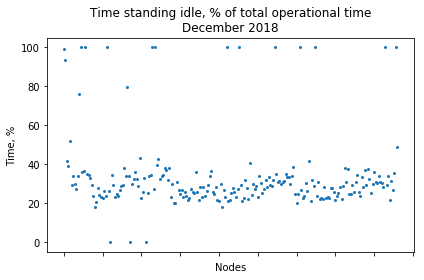

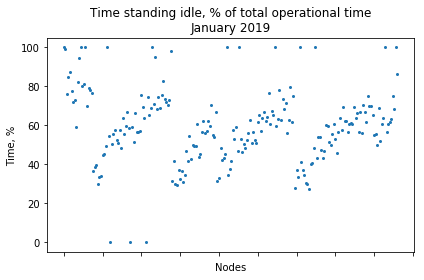

In [33]:
for df_name in nodes_df_names:
    fig, ax = plt.subplots()
    month_df = nodes_no_drop_df_dict[df_name]
    data = month_df.loc['idle_time_sec', :] / month_df.loc['working_time_sec', :] * 100.
    N = len(data)
    x = np.arange(N)
        

    y = data
    z = np.poly1d(np.polyfit(x, y, 10))
    plt.scatter(x, y, marker='o', s=4)
#     plt.plot(x, y, marker='o', markersize=1, linewidth=0.5, color=color)
#     plt.plot(x, z(x), color='black', linewidth=1)
        
    plt.ylabel('Time, %')
    plt.xlabel('Nodes')
    plt.xticks(visible=False)
    plt.gca().xaxis.set_label_coords(0.5, -0.05)
    month, year = extract_mm_YYYY(df_name)
    plt.title('Time standing idle, \n% of total operational time\n' + month + ' ' + year)
    plt.legend()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.tight_layout()
#     fig.savefig( os.path.join( Plots_dir, 'Portion_idle_time_of_nodes_' + df_name + '.png'),dpi=900 )
    plt.show()

In [46]:
energy_by_month = pd.DataFrame(data=0, index=nodes_df_names, columns=['total_dcenergy_MWh', 'total_sys_energy_no_drop_MWh'])

for df_name in nodes_df_names:
    energy_by_month.loc[df_name, 'total_dcenergy_MWh'] = nodes_df_dict[df_name].loc['total_dcenergy', :].sum()
    energy_by_month.loc[df_name, 'total_sys_energy_no_drop_MWh'] = nodes_no_drop_df_dict[df_name].loc['sys_energy', :].sum()
    energy_by_month.loc[df_name, 'idle_energy_no_drop_MWh'] = nodes_no_drop_df_dict[df_name].loc['idle_en_integral', :].sum()

energy_by_month = energy_by_month/1000.

energy_by_month.loc[:, 'idle_energy_percent_MWh'] = energy_by_month.idle_energy_no_drop_MWh / \
                                                                energy_by_month.total_sys_energy_no_drop_MWh * 100.

energy_by_month.to_csv

,total_dcenergy_MWh,total_sys_energy_no_drop_MWh,idle_energy_no_drop_MWh,idle_energy_percent_MWh
May2018_idle,14.693392,15.760777,14.541797,92.265735
June2018_idle,24.173116,27.456353,25.584367,93.181957
July2018_idle,21.623925,24.611164,21.278812,86.459997
September2018,22.968813,25.461291,17.673849,69.414586
October2018,27.047608,32.489585,12.852552,39.558990
November2018,26.539778,31.381473,13.148892,41.900175
December2018,33.022540,37.567028,7.881484,20.979791
January2019,19.393103,21.489490,9.385534,43.674995


### Node 3, monthly graph of exhaust temperature vs inlet teperature

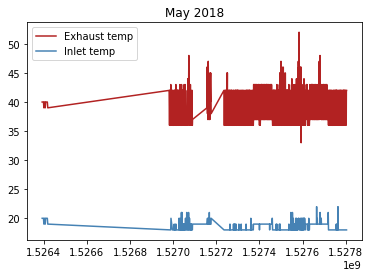

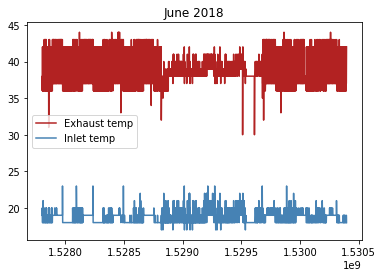

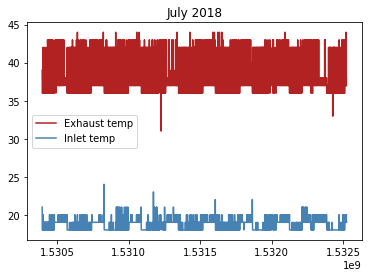

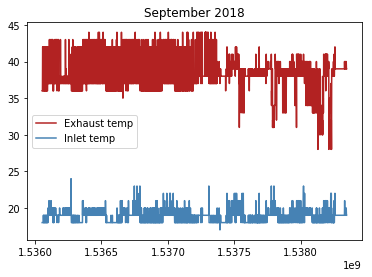

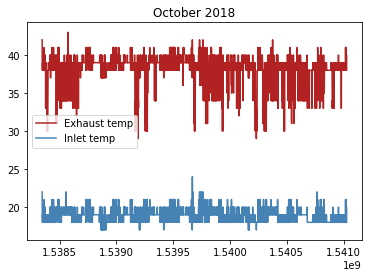

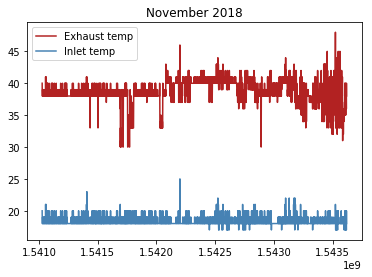

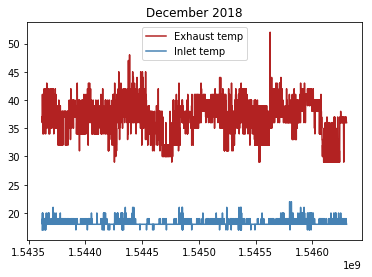

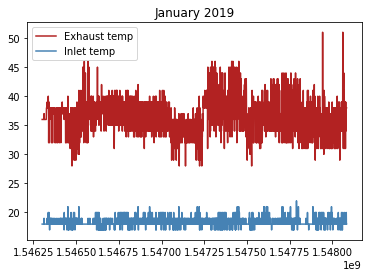

In [17]:
for file_name, df_name in zip(nodes_file_names, nodes_df_names):
    node_df = pd.read_csv( os.path.join( Data_prep_dir, file_name), delimiter=";", header=0 )
    p_exh = plt.plot('timestamp_measure', 'exh_temp', \
                     data=node_df[node_df.nodename=='cresco6x003'], \
                     label='Exhaust temp', color='firebrick')
    p_inlet = plt.plot('timestamp_measure', 'amb_temp', \
                       data=node_df[node_df.nodename=='cresco6x003'], \
                       label='Inlet temp', color='steelblue')
    month, year = extract_mm_YYYY(df_name)
    plt.title(month + ' ' + year)
    plt.legend()
#     p_cpu1 = plt.plot('timestamp_measure', 'cpu1_temp', data=node_df, label='CPU1 temp')
#     p_cpu2 = plt.plot('timestamp_measure', 'cpu2_temp', data=node_df, label='CPU2 temp')
    plt.show()

###  Node 3, monthly difference between exhaust and inlet temperature

c:\users\aagri\appdata\local\programs\python\python35\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


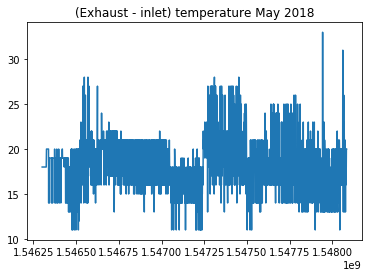

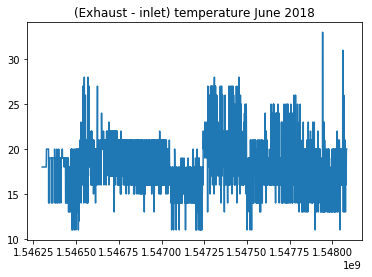

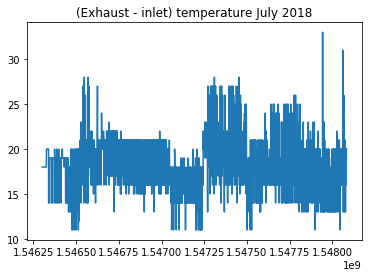

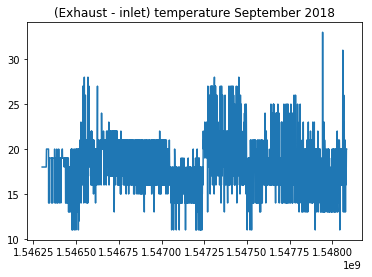

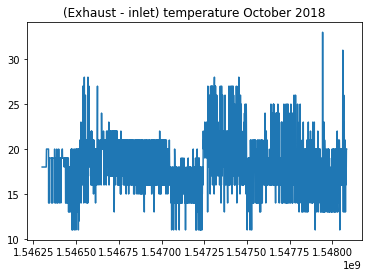

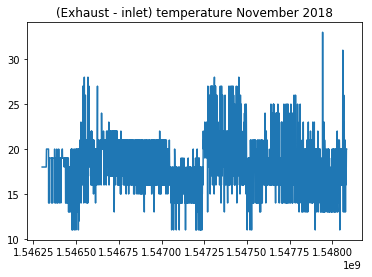

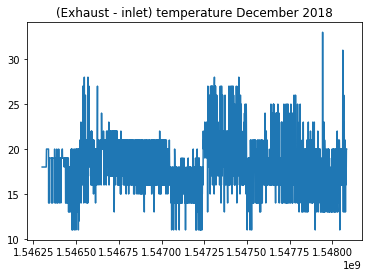

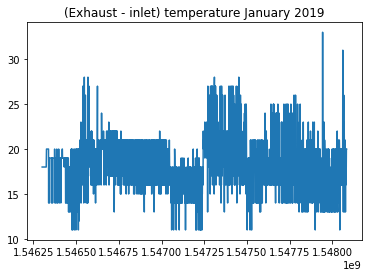

In [18]:
data=node_df[node_df.nodename=='cresco6x003']
for file_name, df_name in zip(nodes_file_names, nodes_df_names):
    node_df = pd.read_csv( os.path.join( Data_prep_dir, file_name), delimiter=";", header=0 )
    p_exh = plt.plot(data.timestamp_measure, data.exh_temp - data.amb_temp, )
    month, year = extract_mm_YYYY(df_name)
    plt.title('(Exhaust - inlet) temperature ' + month + ' ' + year)
    plt.legend()
    plt.show()

###  Node 3, monthly difference between exhaust and inlet temperature
### Scatterplot representation

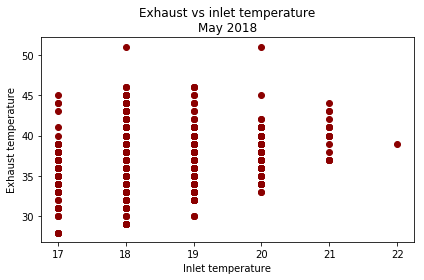

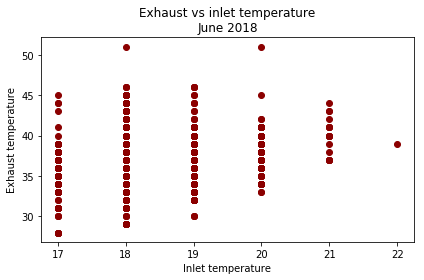

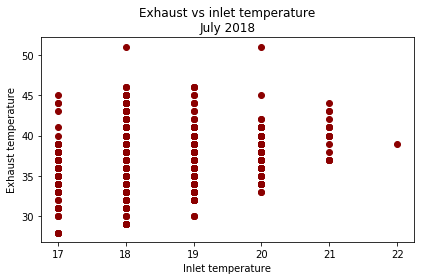

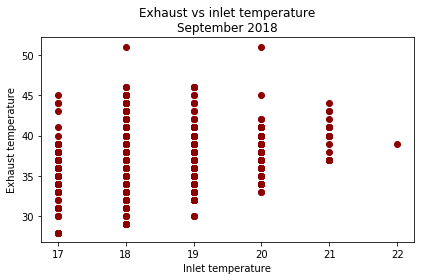

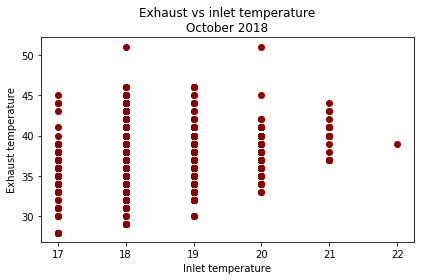

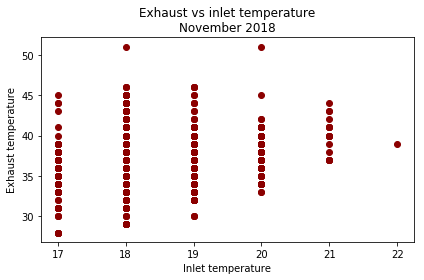

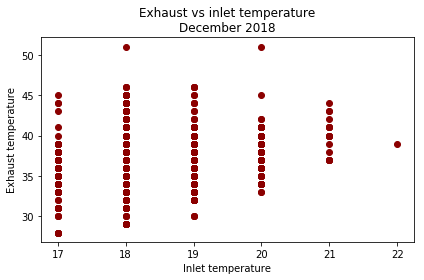

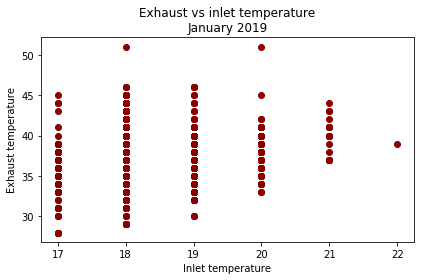

In [20]:
for file_name, df_name in zip(nodes_file_names, nodes_df_names):
    node_df = pd.read_csv( os.path.join( Data_prep_dir, file_name), delimiter=";", header=0 )
    p_exh_vs_inlet = plt.plot(data.amb_temp, data.exh_temp, 'o', color='darkred' )
    month, year = extract_mm_YYYY(df_name)
    plt.title('Exhaust vs inlet temperature\n' + month + ' ' + year)
    plt.xlabel('Inlet temperature')
    plt.ylabel('Exhaust temperature')
    plt.tight_layout()
    plt.show()

## Temperature, fans speed and CPU power trends - September

In [87]:
nodes_stats_Sept = pd.read_csv(os.path.join( Output_dir, 'nodes_stats_September2018.csv'), \
                                         delimiter=";", header=0, index_col=0)
to_drop_ix = np.unique(np.append(\
                                     np.where(nodes_stats_Sept.loc["dcenergy_error_percent", :].isna())[0], \
                                     np.where(nodes_stats_Sept.loc["dcenergy_error_percent", :] > 5.)[0]))
to_drop = nodes_stats_Sept.iloc[:,to_drop_ix].columns.values
node_df_Sept = pd.read_csv(os.path.join( Data_prep_dir, 'September2018.csv'), \
                                         delimiter=";", header=0)
for node in to_drop:
    node_df_Sept.drop(index=node_df_Sept[node_df_Sept.nodename == node].index)

### Normalize and recheck

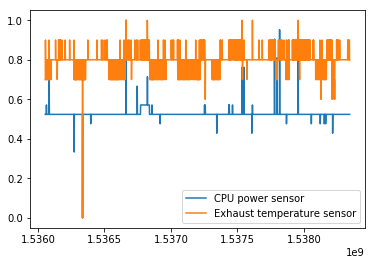

In [88]:
node_Sept_norm = node_df_Sept[node_df_Sept.nodename == node_df_Sept.nodename.unique()[0]].copy()

# node_Sept_norm.loc[:,['cpu_power', 'exh_temp']] = \
#     preprocessing.normalize(node_Sept_norm.loc[:,['cpu_power', 'exh_temp']], norm='max', axis=0)

node_Sept_norm.loc[:, ['cpu_power', 'cpu1_temp', 'cpu2_temp', 'exh_temp']] = \
    preprocessing.normalize(node_Sept_norm.loc[:, ['cpu_power','cpu1_temp', 'cpu2_temp', 'exh_temp']], norm='max', axis=0)
node_Sept_norm.exh_temp = round(node_Sept_norm.exh_temp, 1)
# plt.plot('timestamp_measure', \
#          preprocessing.normalize(node_Sept_norm.loc[:,['cpu_power', 'exh_temp']], norm='max', axis=0))
plt.plot('timestamp_measure','cpu_power', data=node_Sept_norm, label='CPU power sensor')
plt.plot('timestamp_measure','exh_temp', data=node_Sept_norm, label='Exhaust temperature sensor')
plt.legend()
plt.show()

In [75]:
# plt.plot('timestamp_measure','cpu_power', data=node_Sept_norm, label='CPU power sensor')
# plt.show()

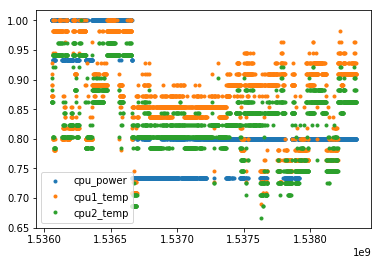

In [9]:
plt.plot('timestamp_measure', 'cpu_power', data=node_Sept_norm, label='cpu_power', linestyle='', marker='.')
plt.plot('timestamp_measure', 'cpu1_temp', data=node_Sept_norm, label='cpu1_temp', linestyle='', marker='.')
plt.plot('timestamp_measure', 'cpu2_temp', data=node_Sept_norm, label='cpu2_temp', linestyle='', marker='.')
plt.legend()
plt.show()

## Fans

In [80]:
# plt.plot('timestamp_measure', 'fan1a', data=node_Sept_norm, label='fan1a')
# plt.plot('timestamp_measure', 'fan2a', data=node_Sept_norm, label='fan2a')
# plt.plot('timestamp_measure', 'fan3a', data=node_Sept_norm, label='fan3a')
# plt.legend()
# plt.show()

In [79]:
# plt.plot('timestamp_measure', 'fan1a', data=node_Sept, label='fan1a')
# plt.plot('timestamp_measure', 'fan1b', data=node_Sept, label='fan1b')
# plt.legend()
# plt.show()

In [78]:
# plt.plot('timestamp_measure', 'fan2a', data=node_Sept, label='fan2a')
# plt.plot('timestamp_measure', 'fan2b', data=node_Sept, label='fan2b')
# plt.legend()
# plt.show()

In [77]:
# plt.plot('timestamp_measure', 'fan3a', data=node_Sept, label='fan3a')
# plt.plot('timestamp_measure', 'fan3b', data=node_Sept, label='fan3b')
# plt.legend()
# plt.show()

## Distance between CPU temperature and CPU power utilization

In [76]:
# plt.plot(abs(node_Sept_norm.cpu_power[:] - node_Sept_norm.cpu1_temp[:]).values, \
#          linestyle='-', marker='.')
# plt.title('Dist(CPU_power, CPU1_temp)')
# plt.legend()
# plt.show()

# plt.plot(abs(node_Sept_norm.cpu_power - node_Sept_norm.exh_temp).values, \
#          linestyle='-', marker='.')
# plt.title('Dist(CPU_power, exhaust_temp)')
# plt.legend()
# plt.show()

# Resume
- no obvious correlation 
        - between fans speed
        - between CPU temperature and CPU power utilization
        - between exhaust temperature and CPU power utilization
(more analysis required)

----
Started analysis of thermal data:
- temperature drop graph for node 3 (the node with all the data present for all months)
- exhaust and inlet temperature of the node
    - line graph
    - scatter plot

----

Graphs finalized, all in two versions, one with dcenergy measurements as primary source, another with integral of sys_power measurements (in this case data is present for all the nodes):
- portions of energy consumed by CPU, memory and other equipment
    - for each month
    - avg for all months
- monthly energy consumption by node, nodes are sorted in the increasing order of energy consumption
- energy consumed by the cluster
    - for each month
    - total sum for all months taking into account all nodes of the cluster 